In [82]:
# Solution set for CS 155 Set 6, 2016/2017
# Authors: Fabian Boemer, Sid Murching, Suraj Nair

import numpy as np
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure

def grad_U(Ui, Yij, Vj, reg, eta, ai, bj):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    first = reg * Ui
    second = Vj * (Yij - (np.dot(Ui, Vj) + ai + bj))
    grad = eta * (first - second)
    return grad

In [83]:
def load_data(filename):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    
    Inputs:
        filename: given as a string.
        
    Outputs:
        Data contained in the file, returned as a numpy ndarray
    """
    return np.loadtxt(filename, dtype = np.str , delimiter='\t')

In [84]:
def grad_V(Vj, Yij, Ui, reg, eta, ai, bj):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    first = reg * Vj
    second = Ui * (Yij - (np.dot(Ui, Vj) + ai + bj))
    grad = eta* (first - second)
    return grad

In [85]:
def get_err(U, V, Y, reg, a , b, m):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    summation = 0
    U_val = np.linalg.norm(U)
    V_val = np.linalg.norm(V)
    for x in range (len(Y)): 
        i = Y[x][0] - 1
        j = Y[x][1] - 1
        yij = Y[x][2]
        dot = np.dot(U[i], V[j])
        summation += (yij - (dot + a[i] + b[j])) ** 2
    return (reg/2) * ((U_val)**2 + (V_val)**2) + (summation/2)

In [86]:
def grad_a(Ui, Yij, Vj, reg, eta, ai, bj): 
    return 2 * (eta/50) * (Yij - (np.dot(Ui, Vj) + ai + bj))

In [87]:
def grad_b(Ui, Yij, Vj, reg, eta, ai, bj): 
    return 2 * (eta/50) * (Yij - (np.dot(Ui, Vj) + ai + bj))

In [88]:
def train_model(M, N, K, eta, reg, Y, m, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    # a is user bias
    a = np.full((M, 1), 0.1)
    # b is movie bias
    b = np.full((N, 1), 0.1)
    first_loss = get_err(U, V, Y, reg, a, b, m)
    for epoch in range(max_epochs): 
        Y_shuffle = np.random.permutation(Y)
        prev_loss = get_err(U, V, Y, reg, a, b, m)
        for x in range (len(Y)): 
            i = Y_shuffle[x][0] - 1
            j = Y_shuffle[x][1] - 1
            y = Y_shuffle[x][2] 
            U[i] -= grad_U(U[i], y, V[j], reg, eta, a[i], b[j])
            V[j] -= grad_V(V[j], y, U[i], reg, eta, a[i], b[j])
            a[i] -= grad_a(U[i], y, V[j], reg, eta, a[i], b[j])
            b[j] -= grad_b(U[i], y, V[j], reg, eta, a[i], b[j])
        if (epoch == 0): 
            first_loss -= get_err(U, V, Y, reg, a , b, m)
        else: 
            error_diff = prev_loss - get_err(U, V, Y, reg, a, b, m)
            if (error_diff/first_loss) <= eps: 
                return (U, V, get_err(U, V, Y, reg, a, b, m)/len(Y), a, b)
    error = get_err(U, V, Y, reg, a, b, m)/len(Y)
    return (U, V, error, a , b)

In [89]:
def get_m(y_train): 
    avg = 0
    for i in y_train: 
        avg += i[2]
    return avg/len(y_train)

In [90]:
Y_train = load_data("data/train.txt")
Y_test = load_data("data/test.txt")
Y_train = np.array([list(map(int, x)) for x in Y_train])
Y_test = np.array([list(map(int, x)) for x in Y_test])
m = get_m(Y_train)
M = max(max(Y_train[:,0]), max(Y_test[:,0])) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
Ks = [10,20,30,50,100]
reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []
Ein = 0
Eout = 0

Factorizing with  943  users,  1682  movies.


In [91]:
result = train_model(M, N, 20, eta, 0.05, Y_train, m)
U = result[0]
V = result[1]
err = result[2]
a = result[3]
b = result[4]
print("Ein: ", err)
Eout = get_err(U, V, Y_test, 0.05, a , b, m)/len(Y_test)
print("Eout: ", Eout)

Ein:  [0.23329141]
Eout:  [0.52031273]


In [92]:
V = np.transpose(V)
A, S, B = np.linalg.svd(V, full_matrices = False)
print(np.shape(A))
A = np.transpose(A)
print(np.shape(A))
A_12 = A[:,0:2]
print(np.shape(A_12))
A_12 = np.transpose(A_12)
print(np.shape(A_12))
V_s = np.dot(A_12, V)
U_s = np.dot(A_12, np.transpose(U))

(20, 20)
(20, 20)
(20, 2)
(2, 20)


In [93]:
print(np.shape(U_s))
print(np.shape(V_s))

(2, 943)
(2, 1682)


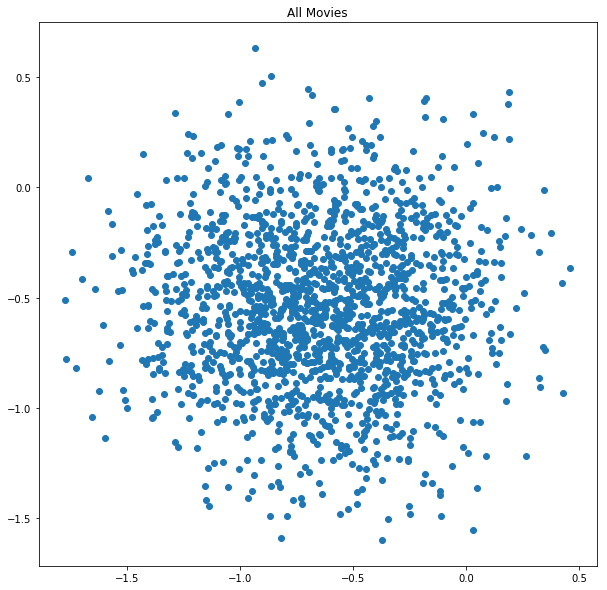

In [94]:
plt.scatter(V_s[0], V_s[1])
plt.title("All Movies")
plt.show()

In [95]:
data = load_data("data/movies.txt")
titles = data[:,0:2]
genres = np.delete(data, 1, axis = 1)

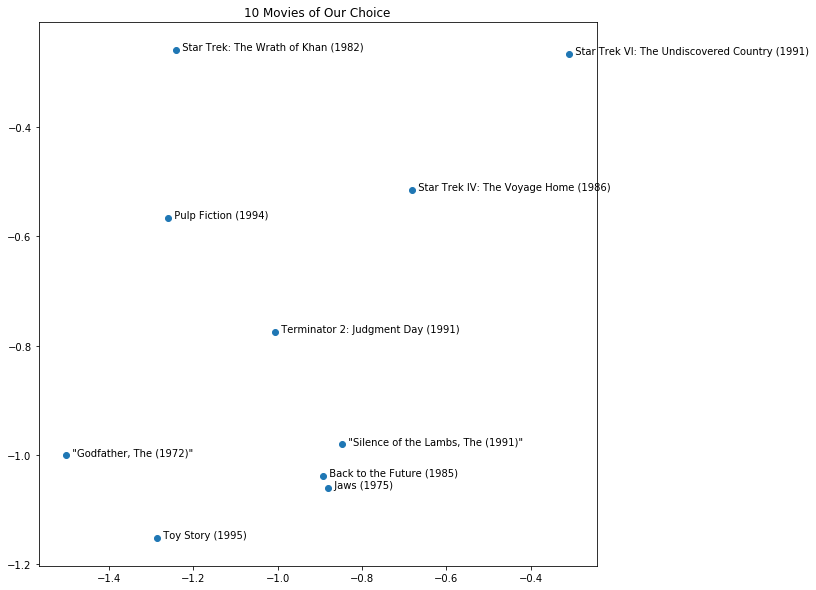

In [96]:

# 10 movies of your choice 
movie_ids = [1, 56, 228, 227, 230, 98, 127, 204, 234, 96]
ten = np.zeros([2, 10])
for j,id in enumerate(movie_ids):
    for i in range(2): 
        ten[i][j] = V_s[i][id - 1]


plt.rcParams["figure.figsize"] = [10,10]

#putting the labels on the points
fig, ax = plt.subplots()
plt.scatter(ten[0], ten[1])
plt.title("10 Movies of Our Choice")



for i, movie_id in enumerate(movie_ids):
    title = str(titles[movie_id - 1][1])
    ax.annotate("  " + title, (ten[0][i], ten[1][i]))
    

plt.show()

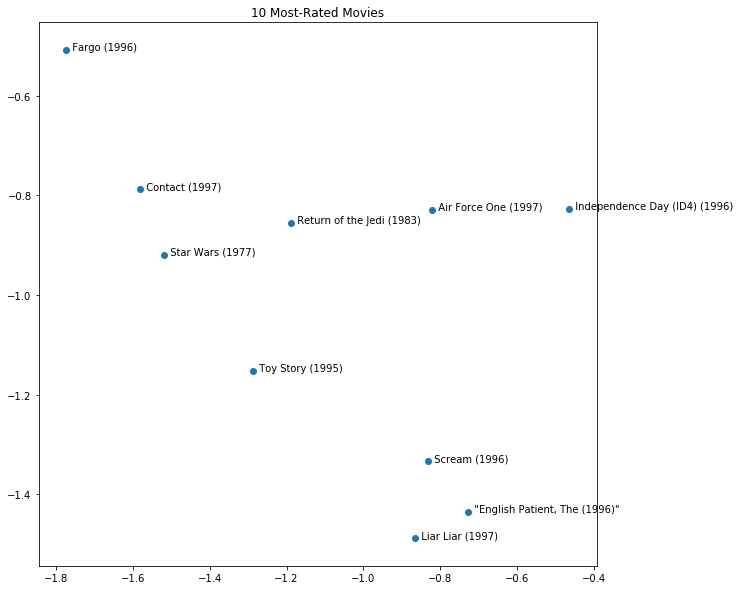

In [97]:
ratings = load_data("data/data.txt")
ratings = ratings.astype(int)
# all ratings of ten most popular movies which recieved the most ratings
x = np.transpose(ratings[:,1])
counts = np.array(np.unique(x, return_counts = True)).T
counts = counts[counts[:,1].argsort()]
popular = counts[-10:,:]

pop = np.zeros([2, 10])
for i in range(2): 
    for j in range(10): 
        pop[i][j] = V_s[i][popular[j][0]-1]

fig, ax = plt.subplots()
plt.scatter(pop[0], pop[1])
plt.title("10 Most-Rated Movies")

movie_ids = np.transpose(popular[:,0]).tolist()

for i, movie_id in enumerate(movie_ids):
    title = str(titles[movie_id - 1][1])
    ax.annotate("  " + title, (pop[0][i], pop[1][i]))

plt.show()

[[-1.41972629 -1.1385592  -1.37843575 -1.21417451 -1.37478321 -1.07652048
  -1.02602823 -1.36307875 -1.51893853 -1.01118697]
 [-0.34381981 -1.44553865 -0.61543425 -0.90161262 -0.25729346 -1.24511969
  -0.72397995 -0.70338768 -0.91901173 -0.90234137]]


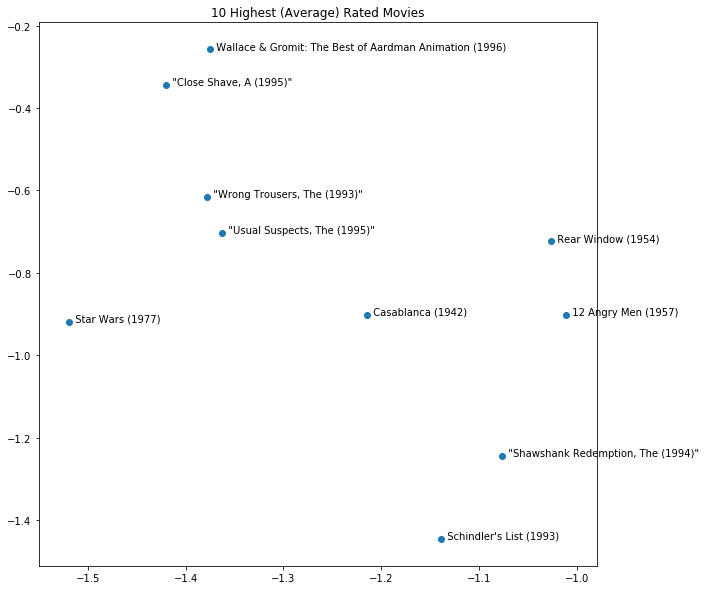

In [98]:
# all ratings of ten best movies with highest average ratings
av = {}
for i in range(len(ratings)):
    name = ratings[i][1]
    if name in av.keys():
        #if the movie already in dictionary
        av[name].append(ratings[i][2])
        
    else:
        av[name] = [ratings[i][2]]

for movie in av.keys():
    #print(str(movie), " ", str(np.mean(av[movie])))
    av[movie] = np.mean(av[movie])

av_movie_ratings = []
for movie_id in av.keys():
    av_movie_ratings.append([movie_id, av[movie_id]])
    
av_movie_ratings = np.asarray(av_movie_ratings)

av_ratings = av_movie_ratings[av_movie_ratings[:,1].argsort()]
av_ratings = av_ratings.tolist()

#get the top 10 with at leat 30 ratings
for i in range(len(av_ratings)):
    id1 = int(av_ratings[i][0])
    #counts is the (id, # of ratings list)
    for j in range(len(counts)):
        id2 = int(counts[j][0])
        if id1 == id2:
            av_ratings[i].append(counts[j][1])
            break
            
av_ratings = (np.asarray(av_ratings))
#noa av_ratings has the counts for that movies as the third column

popular2 = []
j = 1681
while len(popular2) < 10:
    if av_ratings[j][2] >= 30:
        popular2.append([av_ratings[j][0], av_ratings[j][1]])
    j -= 1;

popular2 = np.asarray(popular2)
#print(popular2)

movie_ids = np.transpose(popular2[:,0]).astype(int)
#print(movie_ids)

pop_best = np.zeros([2, 10])
for i in range(2): 
    for j in range(10): 
        pop_best[i][j] = V_s[i][int(popular2[j][0]-1)]

print(pop_best)
fig, ax = plt.subplots()
plt.scatter(pop_best[0], pop_best[1])
plt.title("10 Highest (Average) Rated Movies")

for i, movie_id in enumerate(movie_ids):
    title = str(titles[int(movie_id) - 1][1])
    #print(title)
    ax.annotate("  " + title, (pop_best[0][i], pop_best[1][i]))

plt.show()

X1 Average:  -0.7391742911795187 , Y1 Average:  -0.6838422375164431
X2 Average:  -0.5113097667858684 , Y2 Average:  -0.6957338266610321
X3 Average:  -0.8690371383755081 , Y3 Average:  -0.5129319179018708


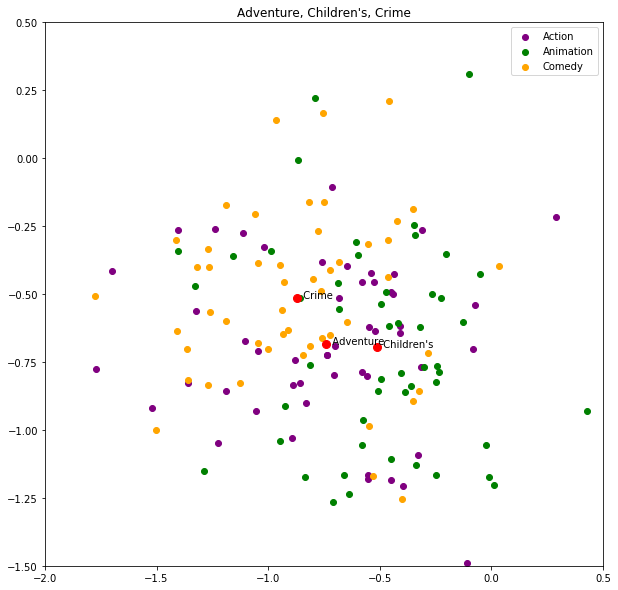

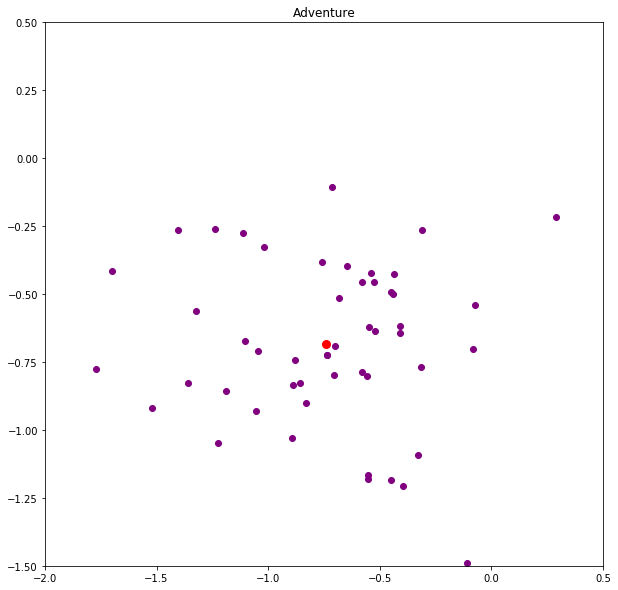

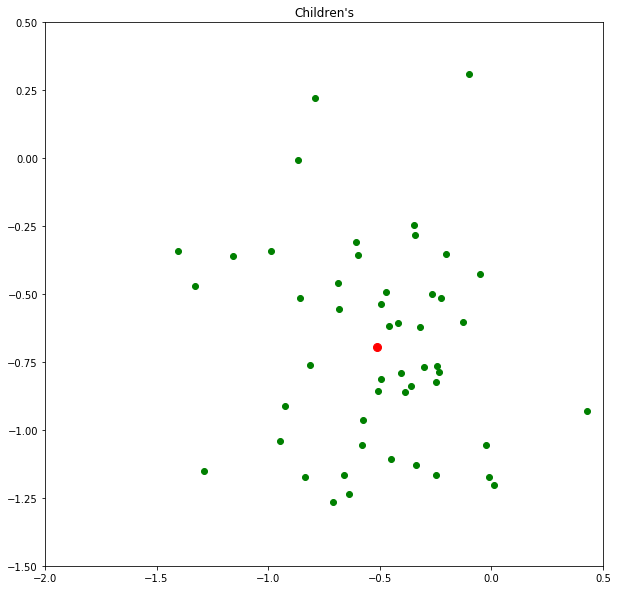

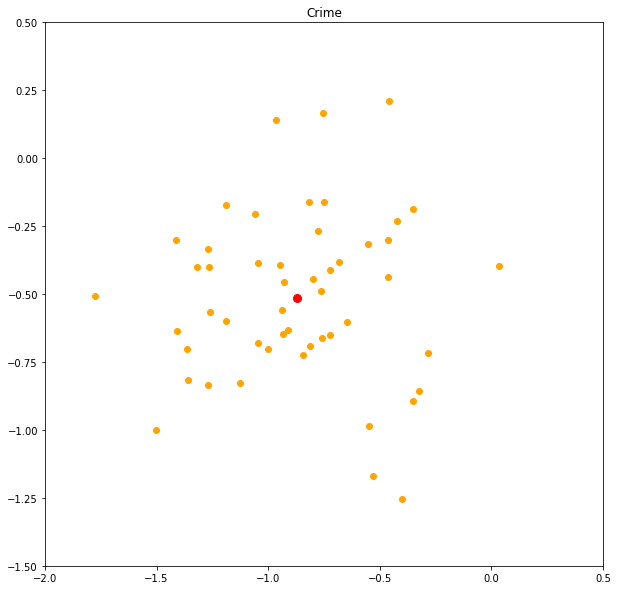

'\nplt.pcolormesh(xi, yi, zi.reshape(xi.shape))\nplt.title("Action")\nplt.colorbar()\nplt.savefig(\'density-Action\')\nplt.axis([-1.4, 0.0, -1.2, -.25])\nplt.show()\n\nplt.pcolormesh(xi1, yi1, zi1.reshape(xi1.shape))\nplt.title("Animation")\nplt.colorbar()\nplt.savefig(\'density-Animation\')\nplt.axis([-1.4, 0.0, -1.2, -.25])\nplt.show()\n\nplt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape))\nplt.title("Comedy")\nplt.colorbar()\nplt.savefig(\'density-Comedy\')\nplt.axis([-1.4, 0.0, -1.2, -.25])\nplt.show()\n\n\n#plt.imshow(combine, cmap=\'hot\', interpolation=\'nearest\')\n#plt.imshow(combine1, cmap=\'hot\', interpolation=\'nearest\')\n#plt.imshow(combine2, cmap=\'hot\', interpolation=\'nearest\')\n\n#plt.scatter(m1[0], m1[1], color = "purple")\n#plt.scatter(m2[0], m2[1], color = "green")\n#plt.scatter(m3[0], m3[1], color = "orange")\n\n'

In [158]:
# 3 Genres of Movies
# Action Movies
genre_1 = genres[:, 3]
genre_1_movieid = []
rating = []
for i in range(len(genre_1)): 
    if genre_1[i] == '1': 
        genre_1_movieid.append(genres[i][0])
m1 = np.zeros([2, 50])
for i in range(2): 
    for j in range(50): 
        index = genre_1_movieid[j]
        #(int(index))
        m1[i][j] = V_s[i][int(index) - 1 ]

# Animation Movies
genre_2 = genres[:, 5]
genre_2_movieid = []
rating2 = []
for i in range(len(genre_2)): 
    if genre_2[i] == '1' and genres[i][0] not in genre_1_movieid: 
        genre_2_movieid.append(genres[i][0])
m2 = np.zeros([2, 50])
for i in range(2): 
    for j in range(50): 
        index = genre_2_movieid[j]
        m2[i][j] = V_s[i][int(index) - 1]

#Comedy
genre_3 = genres[:, 7]
genre_3_movieid = []
rating3 = []
for i in range(len(genre_3)): 
    if genre_3[i] == '1' and genres[i][0] not in genre_1_movieid and genres[i][0] not in genre_2_movieid: 
        genre_3_movieid.append(genres[i][0])
m3 = np.zeros([2, 50])
for i in range(2): 
    for j in range(50): 
        index = genre_3_movieid[j]
        m3[i][j] = V_s[i][int(index) - 1]
movie_ids1 = genre_1_movieid[:30]
movie_ids2 = genre_2_movieid[:30]
movie_ids3 = genre_3_movieid[:30]
from scipy.stats import kde
fig, ax = plt.subplots()

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([m1[0],m1[1]])
xi, yi = np.mgrid[m1[0].min():m1[0].max():nbins*1j, m1[1].min():m1[1].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

k1 = kde.gaussian_kde([m2[0],m2[1]])
xi1, yi1 = np.mgrid[m2[0].min():m2[0].max():nbins*1j, m2[1].min():m2[1].max():nbins*1j]
zi1 = k(np.vstack([xi1.flatten(), yi1.flatten()]))

k2 = kde.gaussian_kde([m3[0],m3[1]])
xi2, yi2 = np.mgrid[m3[0].min():m3[0].max():nbins*1j, m3[1].min():m3[1].max():nbins*1j]
zi2 = k(np.vstack([xi2.flatten(), yi2.flatten()]))


print("X1 Average: ", np.mean(m1[0]), ", Y1 Average: ", np.mean(m1[1]))
print("X2 Average: ", np.mean(m2[0]), ", Y2 Average: ", np.mean(m2[1]))
print("X3 Average: ", np.mean(m3[0]), ", Y3 Average: ", np.mean(m3[1]))
# Make the plot

plt.scatter(m1[0], m1[1], color = "purple")
plt.scatter(m2[0], m2[1], color = "green")
plt.scatter(m3[0], m3[1], color = "orange")
plt.legend(["Action", "Animation", 'Comedy'])
plt.plot([np.mean(m1[0])], [np.mean(m1[1])], marker='o', markersize=8, color="red")
plt.plot([np.mean(m2[0])], [np.mean(m2[1])], marker='o', markersize=8, color="red")
plt.plot([np.mean(m3[0])], [np.mean(m3[1])], marker='o', markersize=8, color="red")

ax.annotate("  Adventure " , (np.mean(m1[0]), np.mean(m1[1])))
ax.annotate("  Children's " , (np.mean(m2[0]), np.mean(m2[1])))
ax.annotate("  Crime " , (np.mean(m3[0]), np.mean(m3[1])))
plt.title("Adventure, Children's, Crime")
plt.xlim((-2, 0.5))
plt.ylim((-1.5, 0.5))
plt.savefig('scatterplot')
plt.show()

plt.scatter(m1[0], m1[1], color = "purple")
plt.plot([np.mean(m1[0])], [np.mean(m1[1])], marker='o', markersize=8, color="red")
plt.xlim((-2, 0.5))
plt.ylim((-1.5, 0.5))
plt.title("Adventure")
plt.show()

plt.scatter(m2[0], m2[1], color = "green")
plt.plot([np.mean(m2[0])], [np.mean(m2[1])], marker='o', markersize=8, color="red")
plt.xlim((-2, 0.5))
plt.ylim((-1.5, 0.5))
plt.title("Children's")
plt.show()

plt.scatter(m3[0], m3[1], color = "orange")
plt.plot([np.mean(m3[0])], [np.mean(m3[1])], marker='o', markersize=8, color="red")
plt.xlim((-2, 0.5))
plt.ylim((-1.5, 0.5))
plt.title("Crime")
plt.show()
'''
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.title("Action")
plt.colorbar()
plt.savefig('density-Action')
plt.axis([-1.4, 0.0, -1.2, -.25])
plt.show()

plt.pcolormesh(xi1, yi1, zi1.reshape(xi1.shape))
plt.title("Animation")
plt.colorbar()
plt.savefig('density-Animation')
plt.axis([-1.4, 0.0, -1.2, -.25])
plt.show()

plt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape))
plt.title("Comedy")
plt.colorbar()
plt.savefig('density-Comedy')
plt.axis([-1.4, 0.0, -1.2, -.25])
plt.show()


#plt.imshow(combine, cmap='hot', interpolation='nearest')
#plt.imshow(combine1, cmap='hot', interpolation='nearest')
#plt.imshow(combine2, cmap='hot', interpolation='nearest')

#plt.scatter(m1[0], m1[1], color = "purple")
#plt.scatter(m2[0], m2[1], color = "green")
#plt.scatter(m3[0], m3[1], color = "orange")

'''

##### comment this part out to erase labels

# for i, movie_id in enumerate(movie_ids1):
#     title = str(titles[int(movie_id) - 1][1])
#     print(title)
#     ax.annotate("  " + title, (m1[0][i], m1[1][i]))

# for i, movie_id in enumerate(movie_ids2):
#     title = str(titles[int(movie_id) - 1][1])
#     print(title)
#     ax.annotate("  " + title, (m2[0][i], m2[1][i]))

# for i, movie_id in enumerate(movie_ids3):
#     title = str(titles[int(movie_id) - 1][1])
#     print(title)
#     ax.annotate("  " + title, (m3[0][i], m3[1][i]))

#plt.show()

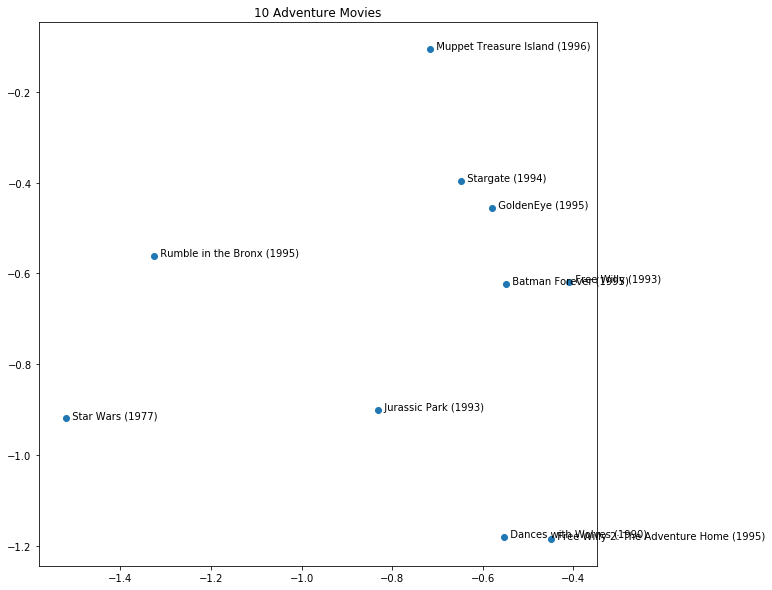

In [159]:
# Animation Movies
# -1.4 0 
# -1.25 -.25

genre_1 = genres[:, 3]
genre_1_movieid = []
rating1 = []
for i in range(len(genre_1)): 
    if genre_1[i] == '1': 
        genre_1_movieid.append(genres[i][0])
m1 = np.zeros([2, 10])
for i in range(2): 
    for j in range(10): 
        index = genre_1_movieid[j]
        m1[i][j] = V_s[i][int(index) - 1]

        
movie_ids = genre_1_movieid[:10]

fig, ax1 = plt.subplots()
plt.scatter(m1[0], m1[1])
plt.title("10 Adventure Movies")

#annotate with movie names
for i, movie_id in enumerate(movie_ids):
    title = str(titles[int(movie_id) - 1][1])
    ax1.annotate("  " + title, (m1[0][i], m1[1][i]))

plt.show()

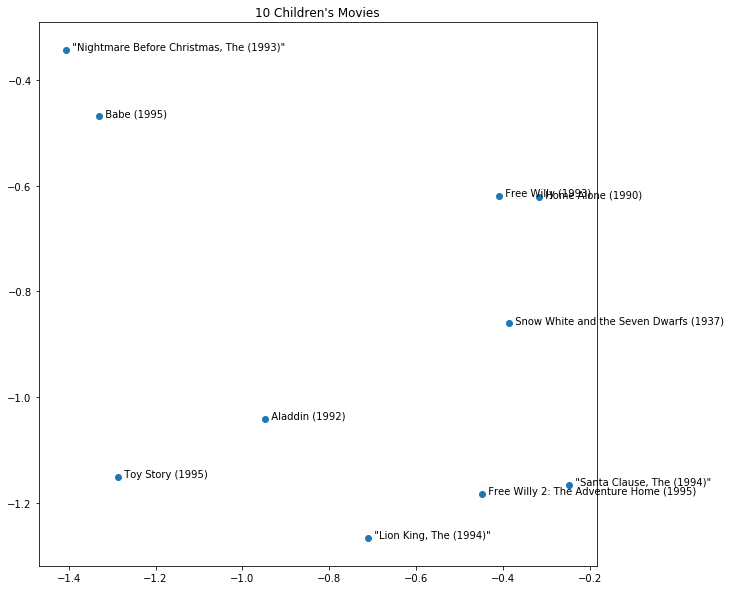

In [160]:
# Animation Movies
# -1.4 0 
# -1.25 -.25

genre_2 = genres[:, 5]
genre_2_movieid = []
rating2 = []
for i in range(len(genre_2)): 
    if genre_2[i] == '1': 
        genre_2_movieid.append(genres[i][0])
m2 = np.zeros([2, 10])
for i in range(2): 
    for j in range(10): 
        index = genre_2_movieid[j]
        m2[i][j] = V_s[i][int(index) - 1]

        
movie_ids = genre_2_movieid[:10]

fig, ax1 = plt.subplots()
plt.scatter(m2[0], m2[1])
plt.title("10 Children's Movies")

#annotate with movie names
for i, movie_id in enumerate(movie_ids):
    title = str(titles[int(movie_id) - 1][1])
    ax1.annotate("  " + title, (m2[0][i], m2[1][i]))

plt.show()

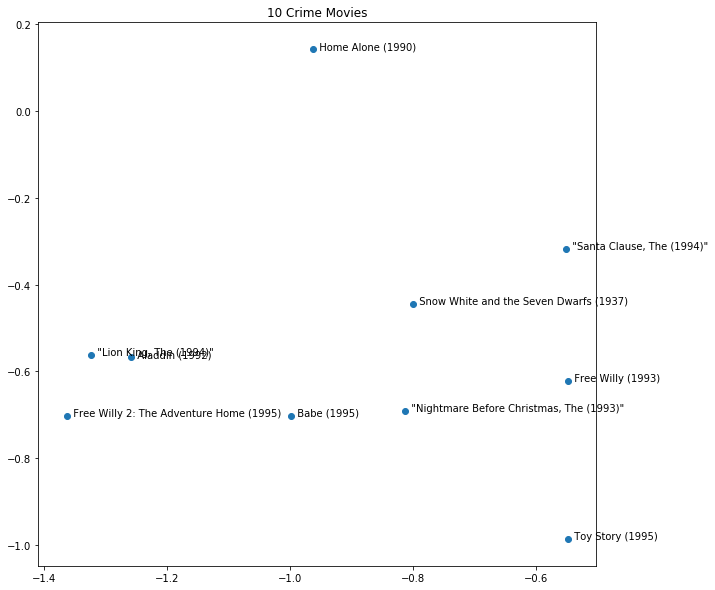

In [161]:
# Comedy
genre_3 = genres[:, 7]
genre_3_movieid = []
rating3 = []
for i in range(len(genre_3)): 
    if genre_3[i] == '1': 
        genre_3_movieid.append(genres[i][0])
m3 = np.zeros([2, 10])
for i in range(2): 
    for j in range(10): 
        index = genre_3_movieid[j]
        m3[i][j] = V_s[i][int(index) - 1]

fig, ax1 = plt.subplots()
plt.scatter(m3[0], m3[1])
plt.title("10 Crime Movies")

for i, movie_id in enumerate(movie_ids):
    title = str(titles[int(movie_id) - 1][1])
    ax1.annotate("  " + title, (m3[0][i], m3[1][i]))
plt.show()

In [102]:
for row in popular:
    id = int(row[0] - 1)
    print(titles[id])

['121' 'Independence Day (ID4) (1996)']
['300' 'Air Force One (1997)']
['1' 'Toy Story (1995)']
['288' 'Scream (1996)']
['286' '"English Patient, The (1996)"']
['294' 'Liar Liar (1997)']
['181' 'Return of the Jedi (1983)']
['100' 'Fargo (1996)']
['258' 'Contact (1997)']
['50' 'Star Wars (1977)']


In [103]:
V_s[:,1]

array([-0.57985891, -0.45561431])